# Exploratory Data Analysis and Feature Importance

In this notebook, we will:
- evaluate the datatset conditions
- look for relationships in within our data
- apply techniques to discover with features are the most important oens

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')

# base folders
CLEAN_DATA_DIR = Path('../clean_data/')

In [4]:
df = pd.read_csv(CLEAN_DATA_DIR / 'engineered_dataset.csv', index_col=0)
df.sample(3)

,FAIR Plan Units,% FAIR Plan Units,Total Exposure ($),% Change - Claims (Fire and Smoke),% Change - Earned Premiums,% Change - Expiring Policies,% Change - Losses (Fire and Smoke),% Change - New Policies,% Change - Nonrenewed Policies,% Change - Nonrenewed Policies (by Company),...,Growth in Losses to All Disasters 10yr Ratio,Growth in Losses to Fire Disasters 3yr Ratio,Growth in Losses to Fire Disasters 5yr Ratio,Growth in Losses to Fire Disasters 10yr Ratio,Premium to Exposure Ratio,Nonrenewal Rate,Loss Burden per Unit,Loss Burden per Exposure,Premium Adequacy,Renewal Resilience
ZIP Code,,,,,,,,,,,,,,,,,,,,,
93510,270.0,0.114650,211748662.0,1.666667,0.371781,0.028310,195.025132,-0.045872,0.349673,0.300000,...,11.472067,39.005026,24.378142,17.729557,6967.663270,0.153538,750.087473,750.087473,9.289134,0.846462
92663,10.0,0.001822,9912034.0,-0.400000,0.335395,0.041903,-0.383656,0.232449,0.361921,0.322581,...,-0.127885,-0.191828,-0.191828,-0.127885,7957.942430,0.117214,916.343961,916.343961,8.684449,0.882786
95815,38.0,0.007186,10846122.0,0.266667,0.343883,0.028886,0.269500,-0.028630,-0.037554,-0.166667,...,0.044917,0.134750,0.134750,0.089833,2768.100794,0.159059,840.101929,840.101929,3.294958,0.840941


In [5]:
targets = df.columns[:3] #['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
features = df.columns[3:]

## Pearson's Correlation

In [6]:
from scipy.stats import pearsonr

corrs = []

for col in features:
    partial_corrs = [col]
    for t in targets:
        corr_coeff, p_value = pearsonr(df[t], df[col])
        partial_corrs += [corr_coeff, p_value]
    
    corrs.append(partial_corrs)

In [7]:
cols = ['Feature']

for t in targets:
    cols.append(t)
    cols.append(f'p-value {t}')

results = pd.DataFrame(corrs, columns=cols).sort_values(by=targets[1])

In [8]:
results

,Feature,FAIR Plan Units,p-value FAIR Plan Units,% FAIR Plan Units,p-value % FAIR Plan Units,Total Exposure ($),p-value Total Exposure ($)
12,% Market Units,-0.686276,5.416394e-163,-1.000000,0.000000e+00,-0.620753,4.668269e-125
71,Renewal Resilience,-0.395227,7.535201e-45,-0.580476,6.805511e-106,-0.393994,1.477853e-44
49,New and Renewed to Total Units Ratio,-0.426708,9.523492e-53,-0.515750,3.619175e-80,-0.279780,2.153735e-22
48,New and Renewed to Nonrenewed Ratio,-0.303102,3.521968e-26,-0.463356,4.628561e-63,-0.323844,7.515912e-30
47,Renewed to Nonrenewed Ratio,-0.299659,1.342634e-25,-0.451673,1.233178e-59,-0.319089,5.537633e-29
...,...,...,...,...,...,...,...
13,% Nonrenewed Policies,0.395227,7.535201e-45,0.580476,6.805511e-106,0.393994,1.477853e-44
67,Nonrenewal Rate,0.395227,7.535201e-45,0.580476,6.805511e-106,0.393994,1.477853e-44
5,% Change - Nonrenewed Policies,0.405411,2.594633e-47,0.631098,1.923524e-130,0.427383,6.309592e-53
1,% Change - Earned Premiums,0.405757,2.131945e-47,0.659696,1.890043e-146,0.400237,4.743158e-46


In [9]:
# results.to_excel('leo_correlations.xlsx', index=False)

## Feature Importance

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Train two random forests to predict the FAIR Plan Units and Total Exposure
forest1 = RandomForestRegressor(n_estimators=500, max_depth=5)
forest1.fit(df_train[features], df_train[targets[0]])

forest2 = RandomForestRegressor(n_estimators=500, max_depth=5)
forest2.fit(df_train[features], df_train[targets[1]])

forest3 = RandomForestRegressor(n_estimators=500, max_depth=5)
forest3.fit(df_train[features], df_train[targets[2]])

RandomForestRegressor(max_depth=5, n_estimators=500)

In [12]:
importance = pd.DataFrame({
    'Feature': features,
    'Imp. # FAIR)': forest1.feature_importances_,
    'Imp. (% FAIR)': forest2.feature_importances_,
    'Imp. (Exposure)': forest3.feature_importances_
}).sort_values(by='Imp. (% FAIR)', ascending=False)

importance

,Feature,Imp. # FAIR),Imp. (% FAIR),Imp. (Exposure)
12,% Market Units,0.349707,0.992433,0.170123
6,% Change - Nonrenewed Policies (by Company),0.000806,0.001406,0.006926
2,% Change - Expiring Policies,0.005936,0.000755,0.001509
5,% Change - Nonrenewed Policies,0.002056,0.000632,0.002905
7,% Change - Nonrenewed Policies (by Owner),0.006714,0.000510,0.001586
...,...,...,...,...
18,All Disasters 3y,0.000271,0.000014,0.000759
16,All Disasters 10y,0.000917,0.000012,0.000317
28,Fire Disasters 5y,0.000796,0.000011,0.000219
27,Fire Disasters 3y,0.000187,0.000005,0.000148


In [13]:
# importance.to_csv ('leo_feature_importance.csv', index=False)

## Ambiguous Variables

Sometimes different data sources provide information about similar features. Here we explore some of the repeated features to decide what we should use in the project. 

### House Value vs. ZHPI

US Census Bureau provides data for Median Home Value (for households with the homeowner living in it) as well as Zillow publishes a (Zillow Housing Price Index)[https://www.zillow.com/research/data/] which provides a typical values for a home in specific region.

As the graph below shows, they are closely correlated as expected. However, census data is capped at $2,000,001, which skewes the data, hence ZHVI is a preferable feature. 

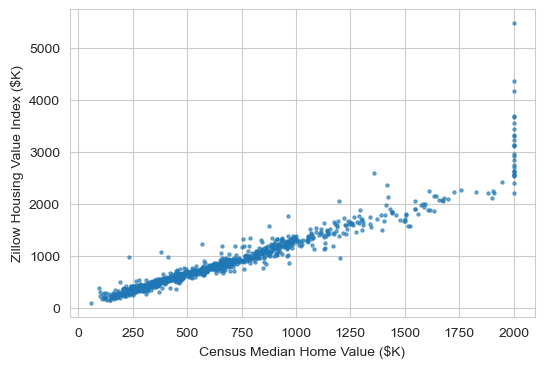

In [15]:
plt.figure(figsize=(6,4))

plt.scatter(df['Median Home Value - Census ($)']/1000, df['Zillow Home Value 2021 ($)']/1000, s=5, alpha=.6)

plt.ylabel('Zillow Housing Value Index ($K)')
plt.xlabel('Census Median Home Value ($K)')

plt.show()

### Housing Units vs. Total Residential Units

Another issue is to have a reliable estimate for the total of residential units in a given zipcode, either to calculate the percentage of FAIR Plan coverage or to include that in the model as a control variable. Here we compare data from the census with the "Total Residental Units" measure provided in the 2022 FAIR Plan data.

Based on the info below, there seems to be a strong correlation betwen the datasets *in the upper bound the FAIR Plan data*. That means that the FAIR Plan dataset rarely gives higher values than the census data, but the opposite is not necessarily true. Considering the description of the datasets, it seems that FAIR Plan data doesn't include residential units under corporate policies--that is, corporate-owner properties like multi-unit apartment complexes.

We have only "Total Residential Units" for 2022, and "Housing Units" from the census doesn't seem to be an adequate proxy for that.

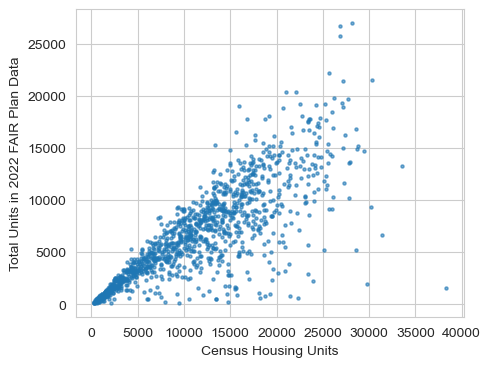

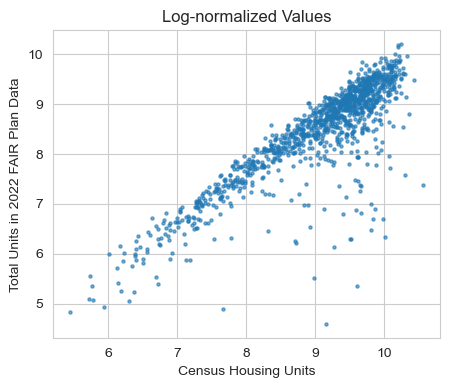

In [57]:
plt.figure(figsize=(5,4))

plt.scatter(df['Housing Units'], df['Total Res Units'], s=5, alpha=.6)

plt.xlabel('Census Housing Units')
plt.ylabel('Total Units in 2022 FAIR Plan Data')

plt.show()

plt.figure(figsize=(5,4))

plt.scatter(np.log(df['Housing Units']), np.log(df['Total Res Units']), s=5, alpha=.6)

plt.title("Log-normalized Values")
plt.xlabel('Census Housing Units')
plt.ylabel('Total Units in 2022 FAIR Plan Data')

plt.show()

In [28]:
# Differece between n. of units
abs(df['Housing Units'] - df['Total Res Units']).describe()


count     1165.000000
mean      4686.568240
std       4316.143914
min          1.000000
25%       1270.000000
50%       3665.000000
75%       6693.000000
max      36700.000000
dtype: float64